The task is to train a network to discriminate between sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings 
warnings.filterwarnings(action='ignore')

# Step-1: Data Gathering

In [3]:
df=pd.read_csv('sonar_dataset.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock


In [4]:
df[0:1]

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.02,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.018,0.0084,0.009,0.0032,Rock


In [5]:
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
75,0.0202,0.0104,0.0325,0.0239,0.0807,0.1529,0.1154,0.0608,0.1317,0.1370,...,0.0127,0.0081,0.0067,0.0043,0.0065,0.0049,0.0054,0.0073,0.0054,Rock
125,0.0228,0.0853,0.1000,0.0428,0.1117,0.1651,0.1597,0.2116,0.3295,0.3517,...,0.0172,0.0191,0.0260,0.0140,0.0125,0.0116,0.0093,0.0012,0.0036,Mine
98,0.1313,0.2339,0.3059,0.4264,0.4010,0.1791,0.1853,0.0055,0.1929,0.2231,...,0.0362,0.0210,0.0154,0.0180,0.0013,0.0106,0.0127,0.0178,0.0231,Mine
92,0.0260,0.0192,0.0254,0.0061,0.0352,0.0701,0.1263,0.1080,0.1523,0.1630,...,0.0118,0.0120,0.0051,0.0070,0.0015,0.0035,0.0008,0.0044,0.0077,Rock
197,0.0366,0.0421,0.0504,0.0250,0.0596,0.0252,0.0958,0.0991,0.1419,0.1847,...,0.0132,0.0027,0.0022,0.0059,0.0016,0.0025,0.0017,0.0027,0.0027,Mine


In [6]:
df.shape

(208, 61)

In [7]:
df.isna().sum() # isnull() and isna() literally does the same things. isnull() is just an alias of the isna() method as shown in pandas source code.

0     0
1     0
2     0
3     0
4     0
     ..
56    0
57    0
58    0
59    0
60    0
Length: 61, dtype: int64

In [8]:
df.columns # 60 is the target column

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
           dtype='int64')

In [9]:
df[60]

0      Rock
1      Rock
2      Rock
3      Rock
4      Rock
       ... 
203    Mine
204    Mine
205    Mine
206    Mine
207    Mine
Name: 60, Length: 208, dtype: object

In [10]:
df[60].value_counts()

Mine    111
Rock     97
Name: 60, dtype: int64

# Step-2: Data Preprocessing

In [11]:
x=df.drop(60, axis=1) # axis=1/column refrers column 
x.shape

(208, 60)

In [12]:
y=df[60]
y.shape

(208,)

    | One Hot Encoding

In [13]:
y=pd.get_dummies(y,drop_first=True)
y # 0--> Mine and 1--> Rock 

,Rock
0,1
1,1
2,1
3,1
4,1
...,...
203,0
204,0
205,0
206,0


In [14]:
y.value_counts()

Rock
0       111
1        97
dtype: int64

    | Train and Test split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
xtrain, xtest, ytrain, ytest=train_test_split(x,y,test_size=0.25, random_state=5)

In [17]:
xtrain.shape,xtest.shape

((156, 60), (52, 60))

In [18]:
xtrain

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
50,0.0353,0.0713,0.0326,0.0272,0.0370,0.0792,0.1083,0.0687,0.0298,0.0880,...,0.0098,0.0163,0.0242,0.0043,0.0202,0.0108,0.0037,0.0096,0.0093,0.0053
55,0.0201,0.0116,0.0123,0.0245,0.0547,0.0208,0.0891,0.0836,0.1335,0.1199,...,0.0032,0.0076,0.0045,0.0056,0.0075,0.0037,0.0045,0.0029,0.0008,0.0018
77,0.0336,0.0294,0.0476,0.0539,0.0794,0.0804,0.1136,0.1228,0.1235,0.0842,...,0.0033,0.0150,0.0111,0.0032,0.0035,0.0169,0.0137,0.0015,0.0069,0.0051
23,0.0115,0.0150,0.0136,0.0076,0.0211,0.1058,0.1023,0.0440,0.0931,0.0734,...,0.0107,0.0091,0.0016,0.0084,0.0064,0.0026,0.0029,0.0037,0.0070,0.0041
45,0.0408,0.0653,0.0397,0.0604,0.0496,0.1817,0.1178,0.1024,0.0583,0.2176,...,0.0066,0.0062,0.0129,0.0184,0.0069,0.0198,0.0199,0.0102,0.0070,0.0055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.0299,0.0688,0.0992,0.1021,0.0800,0.0629,0.0130,0.0813,0.1761,0.0998,...,0.0342,0.0459,0.0277,0.0172,0.0087,0.0046,0.0203,0.0130,0.0115,0.0015
118,0.0363,0.0478,0.0298,0.0210,0.1409,0.1916,0.1349,0.1613,0.1703,0.1444,...,0.0250,0.0115,0.0190,0.0055,0.0096,0.0050,0.0066,0.0114,0.0073,0.0033
189,0.0158,0.0239,0.0150,0.0494,0.0988,0.1425,0.1463,0.1219,0.1697,0.1923,...,0.0223,0.0121,0.0108,0.0057,0.0028,0.0079,0.0034,0.0046,0.0022,0.0021
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0042,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048


In [19]:
ytrain

,Rock
50,1
55,1
77,1
23,1
45,1
...,...
144,0
118,0
189,0
206,0


# Step-3: Build an ANN model

In [20]:
model=keras.Sequential([
    keras.layers.Dense(60, input_dim=60,activation='relu'),
    keras.layers.Dense(30 ,activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


In [21]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']) # compile the model
model .fit(xtrain,ytrain, epochs=100,batch_size=8) # train the model ANN | batch_size=8 refers Batch GD

Epoch 1/100
20/20 [==============================] - 1s 4ms/step - loss: 0.6914 - accuracy: 0.5064
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6410
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.7436
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5445 - accuracy: 0.7821
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5055 - accuracy: 0.7885
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4952 - accuracy: 0.7628
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4546 - accuracy: 0.8141
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4687 - accuracy: 0.7821
Epoch 9/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4087 - accuracy: 0.8397
Epoch 10/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3871 - accuracy: 0.8333
Epoch 11/

In [22]:
model.evaluate(xtest,ytest) # model performence/accuracy

2/2 [==============================] - 1s 4ms/step - loss: 0.6648 - accuracy: 0.8077


[0.6647927165031433, 0.807692289352417]

In [23]:
y_pred=model.predict(xtest).reshape(-1)
print(y_pred[:10])

y_pred=np.round(y_pred) # round the values to nearest integer i.e. 0 or 1
print(y_pred[:10])


2/2 [==============================] - 0s 3ms/step
[5.2469230e-05 9.9999225e-01 2.8996730e-02 1.9306070e-01 9.8958814e-01
 3.0759697e-05 8.7265134e-02 9.9999690e-01 2.7899488e-04 9.9999911e-01]
[0. 1. 0. 0. 1. 0. 0. 1. 0. 1.]


In [24]:
ytest[:10]

,Rock
156,0
21,1
193,0
159,0
34,1
196,0
6,1
25,1
115,0
51,1


In [25]:
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
print(classification_report(ytest,y_pred))  # classification

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.73      0.80      0.76        20

    accuracy                           0.81        52
   macro avg       0.80      0.81      0.80        52
weighted avg       0.81      0.81      0.81        52



# Steps-5: Dropout Regularization

In [27]:
model_d=keras.Sequential([
    keras.layers.Dense(60, input_dim=60,activation='relu'),
    keras.layers.Dropout(.5), # it will drop 50% of the neurons | reduce accuracy
    keras.layers.Dense(30 ,activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(1, activation='sigmoid')
])


In [28]:
model_d.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']) # compile the model
model_d.fit(xtrain,ytrain, epochs=100,batch_size=8) # train the model ANN | batch_size=8 refers Batch GD

Epoch 1/100
20/20 [==============================] - 1s 4ms/step - loss: 0.7397 - accuracy: 0.5256
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7374 - accuracy: 0.4295
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5449
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.5000
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.5064
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7072 - accuracy: 0.4872
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.6090
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5641
Epoch 9/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5256
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5321
Epoch 11/

In [29]:
model_d.evaluate(xtest,ytest) # model performence/accuracy

2/2 [==============================] - 0s 4ms/step - loss: 0.3576 - accuracy: 0.7692


[0.35759085416793823, 0.7692307829856873]

    | Prediction

In [30]:
y_pred=model_d.predict(xtest).reshape(-1) 
print(y_pred[:10])

y_pred=np.round(y_pred) # round the values to nearest integer i.e. 0 or 1
print(y_pred[:10])

2/2 [==============================] - 0s 4ms/step
[0.0351833  0.8768711  0.1392344  0.19088408 0.66685784 0.04063271
 0.779308   0.99268955 0.25898322 0.99617505]
[0. 1. 0. 0. 1. 0. 1. 1. 0. 1.]


In [31]:
ytest[:10]

,Rock
156,0
21,1
193,0
159,0
34,1
196,0
6,1
25,1
115,0
51,1


    | Confusion metrics

In [32]:
cm=tf.math.confusion_matrix(labels=ytest, predictions=y_pred)
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[26,  6],
       [ 6, 14]])>

Text(66.5, 0.5, 'Truth')

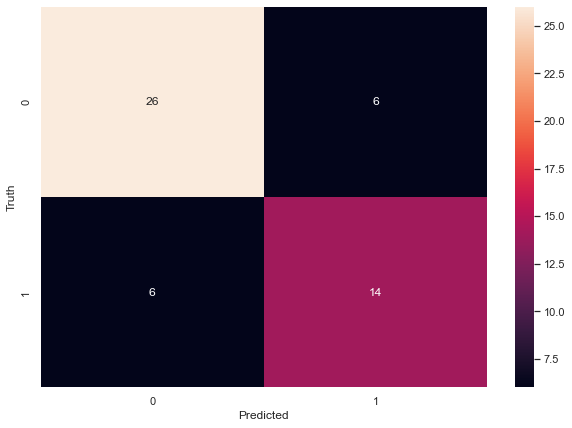

In [33]:
plt.figure(figsize=(10,7))
sns.set(style='white')
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')